In [199]:
%matplotlib inline
import glob
import matplotlib.pyplot as plt
import pandas
import pulp

pandas.set_option('display.width', 1000)

In [200]:
# create dataframe of past salaries and past performance
list = []
for file in glob.glob('../Data/SalaryHistory/*.csv'):
    list.append(pandas.read_csv(file, sep=';'))
pastsalaries = pandas.concat(list)
pastsalaries['DK Salary'] = pastsalaries['DK Salary'].astype(str).map(
    lambda ele: ele if ele == 'nan' else int(ele.replace('$', '').replace(',', '')))
del list

pastsalaries.head()

,Date,GID,Pos,Name,Starter,DK Pts,DK Salary,Team,H/A,Oppt,Team Score,Oppt Score,Minutes,Stat line
0,20160306,4224,SG,"Harden, James",1,71.75,10500,hou,A,tor,113,107,42.68,40pt 5rb 14as 1st 1to 3trey 11-20fg 15-19ft
1,20160306,4079,PG,"Westbrook, Russell",1,49.50,10800,okc,A,mil,104,96,38.83,15pt 10rb 11as 1st 1bl 7to 1trey 3-7fg 8-11ft
2,20160306,4369,PG,"Jackson, Reggie",1,48.75,6600,det,H,por,123,103,34.08,30pt 1rb 9as 2st 1to 1trey 11-19fg 7-7ft
3,20160306,4885,SG,"Booker, Devin",1,47.50,4800,pho,A,mem,109,100,42.82,27pt 2rb 9as 1st 1bl 3to 4trey 8-17fg 7-7ft
4,20160306,3891,PG,"Lowry, Kyle",1,42.00,8800,tor,H,hou,107,113,38.28,17pt 4rb 9as 3st 3to 4trey 5-10fg 3-5ft


In [201]:
# choose an arbitrary date
date = 20160301

In [202]:
# isolate data for specific date
specificDate = pastsalaries[pastsalaries['Date'] == date]

# exclude players with missing salaries
specificDate = specificDate[specificDate['DK Salary'] != 'nan']

In [203]:
# initialize variables
playerPositions = specificDate['Pos'].tolist()
teams = specificDate['Team'].tolist()
playerNames = specificDate['Name'].tolist()
playerTeams = tuple(specificDate['Team'].unique())
playerCosts = tuple(specificDate['DK Salary'])
playerPoints = tuple(specificDate['DK Pts'])
salaryCap = 50000
numOfPlayers = range(len(playerCosts))

In [204]:
# formulate linear programming problem
problem = pulp.LpProblem("Optimal Lineup", pulp.LpMaximize)

In [205]:
# create variable to represent each player
playerInLineup = pulp.LpVariable.dicts("Players", [i for i in numOfPlayers], 0, 1, cat="Binary")

In [206]:
# create objective: maximize sum of player points
problem += pulp.lpSum(playerInLineup[i] * playerPoints[i] for i in numOfPlayers)

In [207]:
# constraint: each player can only be chosen at most once
for i in numOfPlayers:
    problem += pulp.lpSum(playerInLineup[i]) <= 1

In [208]:
# constraints: sum of player costs must be less than or equal to the salary cap
problem += sum(playerInLineup[i] * playerCosts[i] for i in numOfPlayers) <= salaryCap

In [209]:
# constraint: teams must have 8 players
problem += pulp.lpSum(problem.variables()) == 8

In [210]:
# positions
# constraint: 1 <= number of PG <= Max 3
pointguards = tuple(specificDate['Pos'] == 'PG')
problem += pulp.lpSum(playerInLineup[i] * pointguards[i] for i in numOfPlayers) >= 1
problem += pulp.lpSum(playerInLineup[i] * pointguards[i] for i in numOfPlayers) <= 3

# constraint: 1 <= number of SG <= Max 3
shootguards = tuple(specificDate['Pos'] == 'SG')
problem += pulp.lpSum(playerInLineup[i] * shootguards[i] for i in numOfPlayers) >= 1
problem += pulp.lpSum(playerInLineup[i] * shootguards[i] for i in numOfPlayers) <= 3

# constraint: 1 <= number of SF <= Max 3
smallforward = tuple(specificDate['Pos'] == 'SF')
problem += pulp.lpSum(smallforward[i] * playerInLineup[i] for i in numOfPlayers) >= 1
problem += pulp.lpSum(smallforward[i] * playerInLineup[i] for i in numOfPlayers) <= 3

# constraint: 1 <= number of PF <= Max 3
powerfoward = tuple(specificDate['Pos'] == 'PF')
problem += pulp.lpSum(powerfoward[i] * playerInLineup[i] for i in numOfPlayers) >= 1
problem += pulp.lpSum(powerfoward[i] * playerInLineup[i] for i in numOfPlayers) <= 3

# constraint: 1 <= number of C <= Max 2
centers = tuple(specificDate['Pos'] == 'C')
problem += pulp.lpSum(playerInLineup[i] * centers[i] for i in numOfPlayers) <= 2
problem += pulp.lpSum(playerInLineup[i] * centers[i] for i in numOfPlayers) >= 1

In [211]:
# calculated predicted lineup

cost = 0
points = 0

predicted = set()
if problem.solve() == 1:
    for pos in range(len(numOfPlayers)):
        if playerInLineup[pos].value() == 1:
            name = playerNames[pos]
            predicted.add(name)
            cost += playerCosts[pos]
            points += playerPoints[pos]
            print '%25s, Position = %2s, Price = %5.f, Points = %3.2f, Team = %3s' \
                  % (playerNames[pos], playerPositions[pos], playerCosts[pos],
                     playerPoints[pos], teams[pos])
    print '\nTotal Team Cost: %5d\nTotal Team Points: %5.2f' % (cost, points)
else:
    print 'Error finding solution'

        Russell, D'Angelo, Position = PG, Price =  5600, Points = 55.50, Team = lal
            Walker, Kemba, Position = PG, Price =  7700, Points = 50.00, Team = cha
            Matthews, Wes, Position = SG, Price =  4600, Points = 34.75, Team = dal
          Green, Draymond, Position = PF, Price =  8600, Points = 54.75, Team = gsw
          Ilyasova, Ersan, Position = PF, Price =  4400, Points = 41.00, Team = orl
             Johnson, Joe, Position = SF, Price =  5500, Points = 38.25, Team = mia
        Whiteside, Hassan, Position =  C, Price =  8300, Points = 54.00, Team = mia
            Bogut, Andrew, Position =  C, Price =  4400, Points = 36.75, Team = gsw

Total Team Cost: 49100
Total Team Points: 365.00


In [212]:
# create dataframe of past perfect lineups
pastwinners = pandas.read_csv('../Scraping/NumberFire/numberFireBestTeam.csv')
# # strip '$' from Salary, convert to integer
pastwinners['Salary'] = pastwinners['Salary'].map(lambda ele: int(ele.replace('$', '')))

In [213]:
# convert date to alternative format to look up past winners
date = str(int(date))
day = date[6:8][1] if int(date[6:8]) < 10 else date[6:8]
month = date[4:6][1] if int(date[4:6]) < 10 else date[4:6]
year = date[2:4]
date = month + '-' + day + '-' + year

In [214]:
# calculate ideal lineup
ideal = set()
for name in pastwinners[pastwinners['Date'] == date]['PlayerName']:
    name = name.split()
    name = name[1] + ', ' + name[0]
    ideal.add(name)

cost = sum(pastwinners[pastwinners['Date'] == date]['Salary'])
points = sum(pastwinners[pastwinners['Date'] == date]['FP'])

print pastwinners[pastwinners['Date'] == date].head(8)
    
print '\nTotal Team Cost: %5d\nTotal Team Points: %3.2f' % (cost, points)

       Date              PlayerName Position  Salary  Pts   R  A  S  T  B     FP
520  3-1-16     Draymond Green (GS)       PF    8600   15  13  9  4  5  1  54.75
521  3-1-16  Hassan Whiteside (MIA)        C    8300   26  14  1  0  1  4  54.00
522  3-1-16      Kemba Walker (CHA)       PG    8100   26   6  9  1  1  0  50.00
523  3-1-16  D'Angelo Russell (LAL)       PG    5800   39   6  3  1  3  0  55.50
524  3-1-16       Joe Johnson (MIA)       SF    5500   24   5  4  0  2  1  38.25
525  3-1-16   Wesley Matthews (DAL)       SG    4600   21   5  2  2  0  0  34.75
526  3-1-16       Andrew Bogut (GS)        C    4400   19   7  2  2  0  1  36.75
527  3-1-16    Ersan Ilyasova (ORL)       PF    4400   22  10  0  2  0  0  41.00

Total Team Cost: 49700
Total Team Points: 365.00


In [215]:
# load data frame to compare outputs
idealvspredicted = pandas.read_csv('../Data/idealversuspredicted.csv', index_col=0)
idealvspredicted = idealvspredicted.sort_values('Date').reset_index(drop=True)
idealvspredicted.head()

,Date,NumberFire Cost,NumberFire Points,Predicted Cost,Predicted Points
0,20151117,49900,377.00,49900,377.00
1,20151119,49700,330.75,49700,330.75
2,20151122,49200,375.25,49800,377.50
3,20151123,49000,386.00,49000,386.00
4,20151124,50000,351.50,50000,351.50


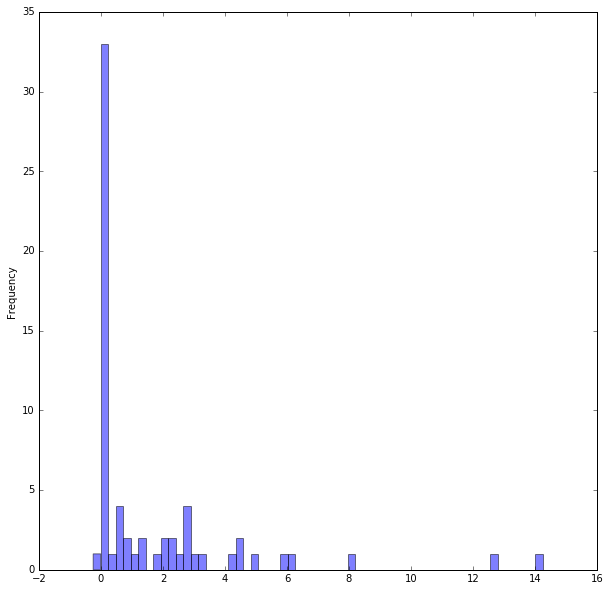

In [218]:
plt.figure(figsize=(10,10))
pointDiff = idealvspredicted['Predicted Points'] - idealvspredicted['NumberFire Points']
pointDiff.plot.hist(alpha=0.5, bins=60)

In [217]:
print 'Above par: %2.2f%%' % (100.0 * sum(pointDiff > 0)/len(pointDiff))
print 'On par:    %2.2f%%' % (100.0 * sum(pointDiff == 0)/len(pointDiff))
print 'Below par: %2.2f%%' % (100.0 * sum(pointDiff < 0)/len(pointDiff))

Above par: 47.69%
On par:    50.77%
Below par: 1.54%
